# Transformer Architecture Implementation (PyTorch)

Imports essential libraries for mathematical operations, type hints, and PyTorch modules to build and manage neural networks.

In [4]:
import math
from typing import Optional


import torch
import torch.nn as nn
import torch.nn.functional as F

# Scaled Dot-Product Attention


Defines the Scaled Dot-Product Attention class, which calculates attention scores between queries (Q) and keys (K), applies a mask if provided, normalizes with softmax, and uses the scores to weight the values (V) to produce the final context and attention outputs.

In [5]:
class ScaledDotProductAttention(nn.Module):
    """Compute scaled dot-product attention.


    Inputs:
        Q: (..., seq_len_q, d_k)
        K: (..., seq_len_k, d_k)
        V: (..., seq_len_v, d_v) where seq_len_k == seq_len_v
        mask: (..., seq_len_q, seq_len_k) with 0 for allowed positions and 1 (or -inf) for masked.


    Returns:
        context: (..., seq_len_q, d_v)
        attn: (..., seq_len_q, seq_len_k)
    """


    def __init__(self, dropout: float = 0.0):
        super().__init__()
        self.dropout = nn.Dropout(dropout) if dropout > 0 else None


    def forward(self, Q, K, V, mask: Optional[torch.Tensor] = None):
        d_k = Q.size(-1)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k) # (..., seq_q, seq_k)


        if mask is not None:
            # mask should be broadcastable to scores' shape. We use -1e9 for numerical stability.
            scores = scores.masked_fill(mask == 0, float('-1e9'))


        attn = F.softmax(scores, dim=-1)
        if self.dropout is not None:
            attn = self.dropout(attn)
        context = torch.matmul(attn, V)
        return context, attn

# Multi-Head Attention


Defines the Multi-Head Attention class, which splits queries, keys, and values into multiple heads, applies scaled dot-product attention to each head, then concatenates and linearly transforms the results to capture information from different representation subspaces.

In [6]:
class MyMultiHeadAttention(nn.Module):
    """Multi-Head Attention as in the paper.


    Splits Q,K,V into h heads, applies scaled dot-product attention, concatenates heads.
    """


    def __init__(self, d_model=512, num_heads=8, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.d_model = d_model
        self.h = num_heads
        self.d_k = d_model // num_heads
        self.d_v = self.d_k


        # linear projections
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_o = nn.Linear(d_model, d_model)


        self.attention = ScaledDotProductAttention(dropout=dropout)
        self.dropout = nn.Dropout(dropout)


    def forward(self, query, key, value, mask: Optional[torch.Tensor] = None):
        # query/key/value: (batch, seq_len, d_model)
        B = query.size(0)


        # linear projections
        Q = self.w_q(query) # (B, seq_q, d_model)
        K = self.w_k(key)
        V = self.w_v(value)


        # split into heads
        Q = Q.view(B, -1, self.h, self.d_k).transpose(1, 2) # (B, h, seq_q, d_k)
        K = K.view(B, -1, self.h, self.d_k).transpose(1, 2) # (B, h, seq_k, d_k)
        V = V.view(B, -1, self.h, self.d_k).transpose(1, 2) # (B, h, seq_v, d_v)


        # adjust mask for heads if provided: expected mask shape -> (B, 1, seq_q, seq_k) or broadcastable
        if mask is not None:
            # ensure mask shape is (B, 1, seq_q, seq_k)
            mask = mask.unsqueeze(1) if mask.dim() == 3 else mask


        # apply attention on all the projected vectors in batch
        context, attn = self.attention(Q, K, V, mask=mask) # context: (B, h, seq_q, d_v)


        # concat heads
        context = context.transpose(1, 2).contiguous().view(B, -1, self.h * self.d_k) # (B, seq_q, d_model)


        output = self.w_o(context)
        output = self.dropout(output)
        return output, attn


# Position-wise Feed-Forward Network


Defines the Position-wise Feed-Forward Network, which applies two linear layers with a ReLU activation and dropout in between to process each position independently in the sequence.

In [7]:
class MyPositionwiseFFN(nn.Module):
    """Two-layer feed-forward network with ReLU activation in between."""


    def __init__(self, d_model=512, d_ff=2048, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)


    def forward(self, x):
        return self.linear2(self.dropout(F.relu(self.linear1(x))))

# Positional Encoding

Defines the Positional Encoding class, which adds fixed sinusoidal position information to input embeddings so the model can understand the order of tokens in a sequence.

In [8]:
class MyPositionalEncoding(nn.Module):
    """Fixed sinusoidal positional encoding as in the paper."""


    def __init__(self, d_model=512, max_len=5000, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout)


        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0) # (1, max_len, d_model)
        self.register_buffer('pe', pe)


    def forward(self, x):
        # x: (B, seq_len, d_model)
        x = x + self.pe[:, : x.size(1), :]
        return self.dropout(x)

# Encoder Layer

Defines the Encoder Layer, which performs self-attention followed by a feed-forward network, using residual connections, dropout, and layer normalization to stabilize training and improve performance.

In [9]:
class MyEncoderLayer(nn.Module):
    def __init__(self, d_model=512, num_heads=8, d_ff=2048, dropout=0.1):
        super().__init__()
        self.self_attn = MyMultiHeadAttention(d_model=d_model, num_heads=num_heads, dropout=dropout)
        self.ffn = MyPositionwiseFFN(d_model=d_model, d_ff=d_ff, dropout=dropout)
        self.norm1 = nn.LayerNorm(d_model, eps=1e-6)
        self.norm2 = nn.LayerNorm(d_model, eps=1e-6)
        self.dropout = nn.Dropout(dropout)


    def forward(self, x, src_mask: Optional[torch.Tensor] = None):
        # Self-attention sublayer
        attn_output, _ = self.self_attn(x, x, x, mask=src_mask)
        x = self.norm1(x + self.dropout(attn_output)) # residual + layernorm


        # Feed-forward sublayer
        ffn_output = self.ffn(x)
        x = self.norm2(x + self.dropout(ffn_output))
        return x

# Decoder Layer

Defines the Decoder Layer, which performs masked self-attention, encoder-decoder (cross) attention, and a feed-forward network—each followed by residual connections, dropout, and layer normalization to maintain stable learning.

In [20]:
class MyDecoderLayer(nn.Module):
    def __init__(self, d_model=512, num_heads=8, d_ff=2048, dropout=0.1):
        super().__init__()
        self.self_attn = MyMultiHeadAttention(d_model=d_model, num_heads=num_heads, dropout=dropout)
        self.cross_attn = MyMultiHeadAttention(d_model=d_model, num_heads=num_heads, dropout=dropout)
        self.ffn = MyPositionwiseFFN(d_model=d_model, d_ff=d_ff, dropout=dropout)
        self.norm1 = nn.LayerNorm(d_model, eps=1e-6)
        self.norm2 = nn.LayerNorm(d_model, eps=1e-6)
        self.norm3 = nn.LayerNorm(d_model, eps=1e-6)
        self.dropout = nn.Dropout(dropout)


    def forward(self, x, enc_output, tgt_mask: Optional[torch.Tensor] = None, memory_mask: Optional[torch.Tensor] = None):
        # Masked self-attention
        self_attn_output, _ = self.self_attn(x, x, x, mask=tgt_mask)
        x = self.norm1(x + self.dropout(self_attn_output))


        # Cross-attention (encoder-decoder attention)
        cross_attn_output, cross_attn_weights = self.cross_attn(x, enc_output, enc_output, mask=memory_mask)
        x = self.norm2(x + self.dropout(cross_attn_output))


        # Feed-forward
        ffn_output = self.ffn(x)
        x = self.norm3(x + self.dropout(ffn_output))
        return x, cross_attn_weights

# Encoder (stack of N layers)

Defines the Encoder, which stacks multiple encoder layers to process the input sequence and extract rich contextual representations.

In [11]:
class MyEncoder(nn.Module):
    def __init__(self, num_layers=6, d_model=512, num_heads=8, d_ff=2048, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([
            MyEncoderLayer(d_model=d_model, num_heads=num_heads, d_ff=d_ff, dropout=dropout)
            for _ in range(num_layers)
        ])


    def forward(self, src, src_mask: Optional[torch.Tensor] = None):
        x = src
        for layer in self.layers:
            x = layer(x, src_mask=src_mask)
        return x

# Decoder (stack of N layers)

Defines the Decoder, which stacks multiple decoder layers to generate the output sequence by attending to both previous target tokens and the encoder’s output.

In [21]:
class MyDecoder(nn.Module):
    def __init__(self, num_layers=6, d_model=512, num_heads=8, d_ff=2048, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([
            MyDecoderLayer(d_model=d_model, num_heads=num_heads, d_ff=d_ff, dropout=dropout)
            for _ in range(num_layers)
        ])


    def forward(self, tgt, enc_output, tgt_mask: Optional[torch.Tensor] = None, memory_mask: Optional[torch.Tensor] = None):
        x = tgt
        all_cross_attns = []
        for layer in self.layers:
            x, cross_attn = layer(x, enc_output, tgt_mask=tgt_mask, memory_mask=memory_mask)
            all_cross_attns.append(cross_attn)
        return x, all_cross_attns

# Full Transformer

Defines the full Transformer model, including token embeddings, positional encoding, stacked encoder and decoder, and a final linear layer to project decoder outputs to the target vocabulary.

In [22]:
class MyTransformer(nn.Module):
    def __init__(
        self,
        src_vocab_size: int,
        tgt_vocab_size: int,
        d_model: int = 512,
        num_heads: int = 8,
        d_ff: int = 2048,
        num_layers: int = 6,
        max_seq_len: int = 512,
        dropout: float = 0.1,
    ):
        super().__init__()
        self.d_model = d_model
        self.src_tok_emb = nn.Embedding(src_vocab_size, d_model)
        self.tgt_tok_emb = nn.Embedding(tgt_vocab_size, d_model)
        self.pos_enc = MyPositionalEncoding(d_model=d_model, max_len=max_seq_len, dropout=dropout)


        self.encoder = MyEncoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads, d_ff=d_ff, dropout=dropout)
        self.decoder = MyDecoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads, d_ff=d_ff, dropout=dropout)


        self.out_proj = nn.Linear(d_model, tgt_vocab_size)


        # initialize parameters as in the paper (xavier)
        self._init_parameters()


    def _init_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)


    def forward(self, src_input, tgt_input, src_mask: Optional[torch.Tensor] = None, tgt_mask: Optional[torch.Tensor] = None, memory_mask: Optional[torch.Tensor] = None):
        # src_input, tgt_input: (B, seq_len) -- token ids
        src_emb = self.src_tok_emb(src_input) * math.sqrt(self.d_model)
        tgt_emb = self.tgt_tok_emb(tgt_input) * math.sqrt(self.d_model)


        src_emb = self.pos_enc(src_emb)
        tgt_emb = self.pos_enc(tgt_emb)


        enc_output = self.encoder(src_emb, src_mask)
        dec_output, cross_attns = self.decoder(tgt_emb, enc_output, tgt_mask=tgt_mask, memory_mask=memory_mask)


        logits = self.out_proj(dec_output) # (B, seq_len_tgt, tgt_vocab_size)
        return logits, cross_attns

# Mask helpers

Provides functions to create attention masks:

- create_padding_mask hides padding tokens,

- create_look_ahead_mask prevents attention to future tokens,

- combine_masks merges padding and look-ahead masks for decoder attention.

In [14]:
def create_padding_mask(seq, pad_token=0):
    """Create a mask to hide padding tokens.


    Returns a mask of shape (batch, 1, 1, seq_len) with 0 for real tokens and 1 for PADs.
    But our attention expects mask with 1 for allowed? In this implementation ScaledDotProductAttention
    masks positions where mask == 0; so we return mask where PAD positions are 0 and others are 1.


    To be consistent, we produce a mask with 1 for allowed positions and 0 for PADs, and later in
    ScaledDotProductAttention we invert with masked_fill(mask == 0, -inf).
    """
    # seq: (B, seq_len)
    mask = (seq != pad_token).unsqueeze(1).unsqueeze(2).to(seq.device) # (B,1,1,seq_len)
    # For broadcasting into (B, h, seq_q, seq_k) or (B, seq_q, seq_k)
    return mask



def create_look_ahead_mask(size):
    """Mask out future positions. Returns (1, size, size) or (size, size) mask with 1s in allowed positions."""
    mask = torch.triu(torch.ones((size, size), dtype=torch.bool), diagonal=1) # upper triangular
    # allowed positions should be True, so invert
    return (~mask).unsqueeze(0) # (1, size, size)



def combine_masks(pad_mask_src=None, pad_mask_tgt=None, look_ahead_mask=None):
    """Combine padding and look-ahead masks into the shape expected by attention.


    Typical uses:
    - src_mask for encoder self-attn: pad_mask_src -> (B,1,1,seq_len_src)
    - tgt_mask for decoder self-attn: combined pad_mask_tgt & look_ahead -> (B,1,seq_len_tgt,seq_len_tgt)
    - memory_mask for cross-attn: pad_mask_src broadcasted -> (B,1,1,seq_len_src) or (B,1,seq_len_tgt,seq_len_src)
    """
    if pad_mask_tgt is not None and look_ahead_mask is not None:
        # pad_mask_tgt: (B,1,1,seq_len_tgt), look_ahead_mask: (1, seq_len_tgt, seq_len_tgt)
        # We want result shape (B, 1, seq_len_tgt, seq_len_tgt)
        B = pad_mask_tgt.size(0)
        seq_len = pad_mask_tgt.size(-1)
        # squeeze pad to (B, seq_len)
        pad = pad_mask_tgt.squeeze(1).squeeze(1).unsqueeze(2) # (B, seq_len, 1)
        look = look_ahead_mask.to(pad_mask_tgt.device).expand(B, -1, -1) # (B, seq_len, seq_len)
        combined = pad & look # (B, seq_len, seq_len)
        return combined.unsqueeze(1) # (B,1,seq_len,seq_len)


    return None

# Visualization function


In [19]:
import matplotlib.pyplot as plt

def plot_attention(attn, head=0):
    # attn: (B, h, seq_q, seq_k)
    attn_matrix = attn[0, head].detach().cpu().numpy() # first batch, selected head
    plt.figure(figsize=(6,6))
    plt.imshow(attn_matrix, cmap='viridis')
    plt.title(f'Attention Heatmap - Head {head}')
    plt.xlabel('Key Position')
    plt.ylabel('Query Position')
    plt.colorbar()
    plt.show()

# Minimal smoke-test / example usage

Runs a test script that creates a dummy Transformer model, generates sample input sequences with padding, builds attention masks, performs a forward pass, and prints the shapes to verify the model works correctly.

src_input shape: torch.Size([2, 10])
tgt_input shape: torch.Size([2, 9])
src_pad_mask shape: torch.Size([2, 1, 1, 10])
tgt_mask shape: torch.Size([2, 1, 9, 9])
logits shape: torch.Size([2, 9, 1000])
Successful forward pass with Base Model hyperparameters!
Plotting cross-attention from the last decoder layer (layer 5, head 0)


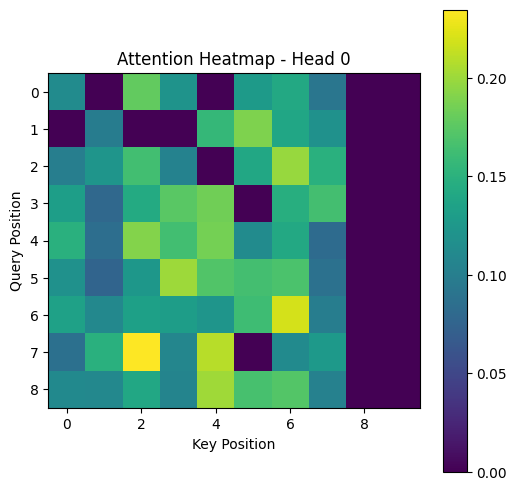

In [23]:
if __name__ == '__main__':
    # Base model hyperparameters
    d_model = 512
    num_heads = 8
    d_ff = 2048
    num_layers = 6
    dropout = 0.1


    # Dummy vocabulary sizes (small for the test)
    src_vocab_size = 1000
    tgt_vocab_size = 1000


    # Dummy batch and sequence lengths
    B = 2
    src_seq_len = 10
    tgt_seq_len = 9


    device = torch.device('cpu')


    # instantiate model
    model = MyTransformer(
    src_vocab_size=src_vocab_size,
    tgt_vocab_size=tgt_vocab_size,
    d_model=d_model,
    num_heads=num_heads,
    d_ff=d_ff,
    num_layers=num_layers,
    max_seq_len=512,
    dropout=dropout,
    ).to(device)


    # Create dummy input token IDs and masks (0 is PAD token)
    src_input = torch.randint(1, src_vocab_size, (B, src_seq_len)).to(device)
    tgt_input = torch.randint(1, tgt_vocab_size, (B, tgt_seq_len)).to(device)


    # Introduce some PAD tokens for testing padding mask
    src_input[0, -2:] = 0
    tgt_input[1, -3:] = 0


    src_pad_mask = create_padding_mask(src_input, pad_token=0) # (B,1,1,src_seq_len)
    tgt_pad_mask = create_padding_mask(tgt_input, pad_token=0) # (B,1,1,tgt_seq_len)


    look_ahead = create_look_ahead_mask(tgt_seq_len) # (1, tgt_seq_len, tgt_seq_len)
    tgt_mask = combine_masks(pad_mask_src=None, pad_mask_tgt=tgt_pad_mask, look_ahead_mask=look_ahead) # (B,1,tgt_seq_len,tgt_seq_len)


    # memory mask shapes need to match (B,1,1,src_seq_len) or (B,1,tgt_seq_len,src_seq_len); here we expand pad
    memory_mask = src_pad_mask.unsqueeze(2) if src_pad_mask.dim() == 4 else src_pad_mask


    print('src_input shape:', src_input.shape)
    print('tgt_input shape:', tgt_input.shape)
    print('src_pad_mask shape:', src_pad_mask.shape)
    print('tgt_mask shape:', tgt_mask.shape)


    logits, cross_attns = model(src_input, tgt_input, src_mask=src_pad_mask.squeeze(2).squeeze(2), tgt_mask=tgt_mask, memory_mask=src_pad_mask)
    # NOTE: In our MyMultiHeadAttention we accept mask shapes that are broadcastable. For clarity we passed
    # different shapes; the attention code will attempt to expand/broadcast.


    print('logits shape:', logits.shape) # expected (B, tgt_seq_len, tgt_vocab_size)


    # Quick assertions
    assert logits.shape == (B, tgt_seq_len, tgt_vocab_size)
    print('Successful forward pass with Base Model hyperparameters!')

    # Plot attention from the last decoder layer, first head
    if cross_attns:
        print(f'Plotting cross-attention from the last decoder layer (layer {len(cross_attns)-1}, head 0)')
        plot_attention(cross_attns[-1], head=0)